<a href="https://colab.research.google.com/github/arunoda/fastai-v4/blob/master/06_4_multi_cat_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loss for the Multi Category Model**

We cannot use CrossEntropyLoss for a Multi Category model. That's because we softmax here. It's possible to have multiple categories to activate. So, the total of activations can be greater than 1.

But individul activation values must be lower than 1. So, we can use sigmoid here for that.

## Setting Up on Colab

You only need to run this on Colab.

In [55]:
!pip install fastai2 > /dev/null 2>&1
!git clone https://github.com/arunoda/fastai-v4 > /dev/null 2>&1
%cd fastai-v4

/content/fastai-v4/fastai-v4


In [0]:
from fastai2.vision.all import *

## Dataset

Here we will use a dataset called PASCAL. Let's inspect it.

In [57]:
dataset = untar_data(URLs.PASCAL_2007)
dataset.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [58]:
train_image_list = (dataset/"train").ls()
train_image_list

(#5012) [Path('/root/.fastai/data/pascal_2007/train/000926.jpg'),Path('/root/.fastai/data/pascal_2007/train/006827.jpg'),Path('/root/.fastai/data/pascal_2007/train/003045.jpg'),Path('/root/.fastai/data/pascal_2007/train/007527.jpg'),Path('/root/.fastai/data/pascal_2007/train/004345.jpg'),Path('/root/.fastai/data/pascal_2007/train/001548.jpg'),Path('/root/.fastai/data/pascal_2007/train/009000.jpg'),Path('/root/.fastai/data/pascal_2007/train/006285.jpg'),Path('/root/.fastai/data/pascal_2007/train/002683.jpg'),Path('/root/.fastai/data/pascal_2007/train/000656.jpg')...]

## Loading images

Here we need to load these images using the `train.csv` file.

In [0]:
df_train = pd.read_csv(dataset/"train.csv")

In [60]:
df_train.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [0]:
def get_x(row):
  return dataset/"train"/row['fname']

def get_y(row):
  return row['labels'].split(' ')

def splitter(df):
  train_ids = df.index[df['is_valid'] == False].tolist()
  valid_ids = df.index[df['is_valid'] == True].tolist()

  return train_ids, valid_ids

db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x = get_x,
    get_y = get_y,
    splitter = splitter,
    item_tfms = RandomResizedCrop(224, min_scale=0.35)
)

In [0]:
dsets = db.datasets(df_train)

In [0]:
x, y = dsets.train[0]

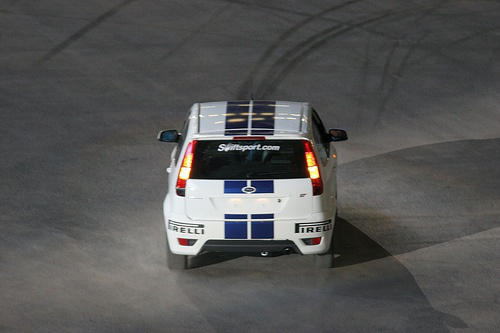

In [64]:
x

In [65]:
y

TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

**See. This is one-hot-encoded list.**

In [66]:
## See. It's a car
dsets.vocab[y == 1]

(#1) ['car']

In [0]:
dls = db.dataloaders(df_train)

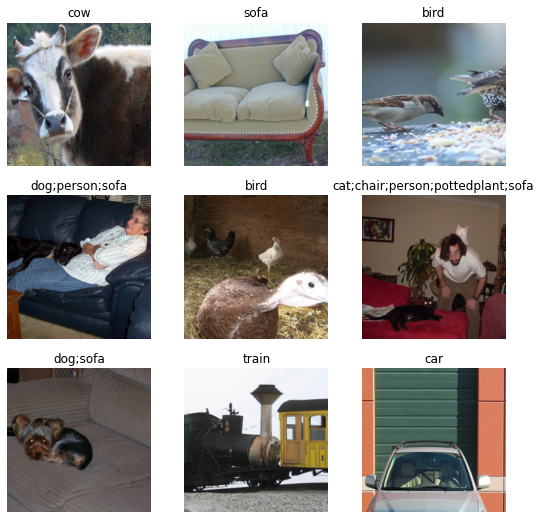

In [68]:
dls.show_batch()

## Creating the Model

In [0]:
## loss function

def multi_loss(inputs, targets):
    # targets are not a tensor. It's a subclass
    # If we make some arithmatic with that, we loose the computational graph
    # hence the grad support
    # so, we copy the underline data like this
    targets = tensor(targets.data)

    inputs = torch.where(inputs <= 0, (inputs - inputs) + 1e-20, inputs)
    inputs = inputs.log().sigmoid()
    loss = ((targets - inputs).abs()).mean()

    return loss


In [0]:
learn = cnn_learner(dls, resnet34, loss_func=multi_loss, metrics=accuracy_multi)

In [71]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.258804,0.173252,0.667829,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.201207,0.141764,0.725896,00:29
1,0.173660,0.094647,0.829562,00:29
2,0.133926,0.060388,0.916374,00:30
3,0.100289,0.048382,0.946693,00:29
4,0.079123,0.045614,0.953247,00:30
5,0.066934,0.045131,0.954900,00:30


In [0]:
## This is the real loss function from fastbook

def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    loss = -torch.where(targets==1, inputs, 1-inputs).log().mean()

    return loss

In [0]:
learn2 = cnn_learner(dls, resnet34, loss_func=binary_cross_entropy, metrics=accuracy_multi)

In [74]:
learn2.fine_tune(6)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.908906,0.601144,0.687191,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.695565,0.518533,0.764960,00:30
1,0.580353,0.333639,0.910179,00:29
2,0.422446,0.179954,0.963725,00:30
3,0.294223,0.122587,0.969482,00:29
4,0.214081,0.108553,0.970677,00:30
5,0.172405,0.107127,0.970498,00:29


**Okay. The default one looks good**